# 001 - Baseline: HistGradientBoostingRegressor

Ce notebook présente la première étape de notre approche pour la compétition House Prices : une baseline robuste.

## Objectifs
1. Charger et inspecter les données.
2. Mettre en place une pipeline de preprocessing propre (sans data leakage).
3. Entraîner un modèle `HistGradientBoostingRegressor`.
4. Évaluer les performances (MAE et MAPE %).
5. Générer une soumission.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import HistGradientBoostingRegressor

sns.set_style("whitegrid")
%matplotlib inline

## 1. Chargement des Données

In [2]:
TRAIN_PATH = "../Data/train.csv"
TEST_PATH = "../Data/test.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (1460, 81)
Test shape: (1459, 80)


## 2. Analyse Rapide

Regardons la distribution de la cible `SalePrice`.

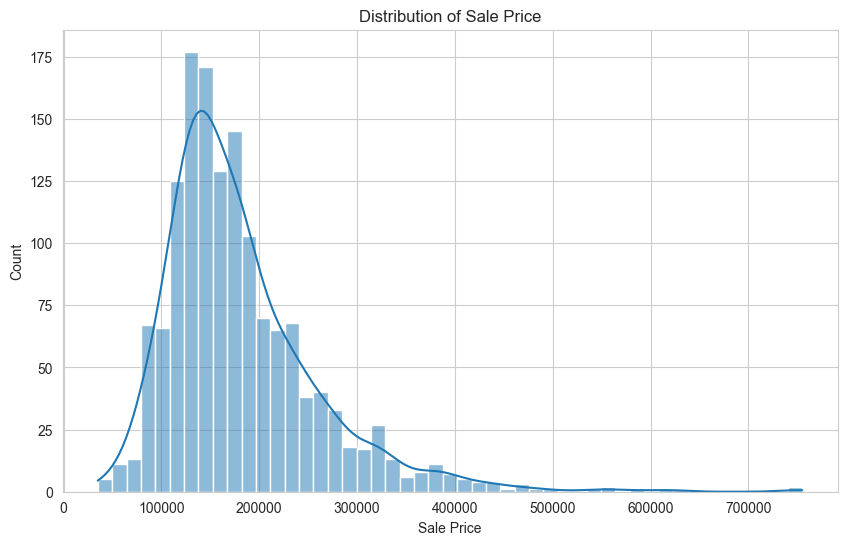

In [3]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Distribution of Sale Price')
plt.xlabel('Sale Price')
plt.show()

## 3. Préparation de la Pipeline

Nous séparons les features numériques et catégorielles pour leur appliquer des traitements différents.

In [4]:
X = train_df.drop(columns=["SalePrice"])
y = train_df["SalePrice"]

# Identification des colonnes
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

print(f"{len(numeric_features)} features numériques")
print(f"{len(categorical_features)} features catégorielles")

37 features numériques
43 features catégorielles


In [5]:
# Preprocessing
numeric_transformer = SimpleImputer(strategy="median")

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Modèle
model = HistGradientBoostingRegressor(random_state=42)

# Pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

## 4. Évaluation (Cross-Validation)

Nous utilisons une 5-Fold Cross-Validation. Nous calculons la MAE (la métrique du leaderboard) et la MAPE (Mean Absolute Percentage Error) pour avoir une idée de la précision en pourcentage.

In [6]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, return_train_score=False)

mae_scores = -scores['test_neg_mean_absolute_error']
mape_scores = -scores['test_neg_mean_absolute_percentage_error']

print(f"MAE moyen: {mae_scores.mean():.2f} +/- {mae_scores.std():.2f}")
print(f"MAPE moyen: {mape_scores.mean() * 100:.2f}% +/- {mape_scores.std() * 100:.2f}%")

MAE moyen: 16918.83 +/- 1725.70
MAPE moyen: 9.74% +/- 1.05%


**Interprétation :** 
La MAPE nous indique le pourcentage d'erreur moyen de nos prédictions par rapport au prix réel.

## 5. Entraînement Final et Soumission

In [7]:
pipeline.fit(X, y)
predictions = pipeline.predict(test_df)

submission = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": predictions
})

submission.head()

,Id,SalePrice
0,1461,124558.097157
1,1462,156922.630206
2,1463,186828.703351
3,1464,183783.183757
4,1465,196742.118223


In [ ]:
# Sauvegarde si besoin (déjà fait par le script src/)
# submission.to_csv("../submissions/submission_baseline_notebook.csv", index=False)